In [9]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [10]:
#Importing csv data
states_data = pd.read_csv('4.18states.csv')
counties = pd.read_csv('abridged_couties.csv')
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

## What are the best features to predict confirmed Covid 19 cases in both Californian counties and US counties?

For our final project, we would like to investigate the Covid 19 datasets and find out what features are the most useful in predicting confirmed cases for counties. We will first start out investigating California only and then move on to the full US dataset. We can compare and contrast the results from California and the entire country to see if there are any interesting simularities. Furthermore, it is a good chance for us to dip our feet into the water and have some sense of what the dataset is like before we move on to the full dataset.

In [13]:
#Cleaning Data to answer the following questions
#We will first create tables only where California is concerned
#We select certain features we thought would be useful and drop the rest (most of which were irrelevant or contained bad data)
ca_data = states_data[states_data["Province_State"] == "California"]
ca_counties = counties[counties["State"] == "California"][["countyFIPS", "PopulationEstimate2018", "FracMale2017", 
"MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", "TotalM.D.'s,TotNon-FedandFed2017", 
"MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]]

#Percentiles should not be negative
ca_counties = ca_counties[ca_counties["SVIPercentile"] > 0]

confirmed_ca = confirmed[confirmed["Province_State"] == "California"]
#We only care about total confirmed cases, which is also the column 4/18/20
confirmed_ca = confirmed_ca[["FIPS", "4/18/20"]]
confirmed_ca.columns = ["countyFIPS", "confirmed"]

#convert FIPS in both dataframes into int so they can be compared when we merge
ca_counties["countyFIPS"] = ca_counties["countyFIPS"].astype(int)
confirmed_ca["countyFIPS"] = confirmed_ca["countyFIPS"].astype(int)
#Merge confirmed columns into counties table using FIPS.
ca_counties = ca_counties.merge(confirmed_ca, on="countyFIPS")
#Dropping rows with NA values. If we filled it with zeros, it would skew the data.
ca_counties = ca_counties.dropna()
#Remove counties without sufficient confirmed data.
ca_counties = ca_counties[ca_counties["confirmed"] > 0]
#We attempt to predict confirmed proportion instead of a flat amount, as it takes into account the size of the counties
#Since we found out that usually these values would be very small, we multiply by 100
ca_counties["confirm_perc"] = (ca_counties["confirmed"]/ca_counties["PopulationEstimate2018"])*100

#
def normalize(col):
    return (col - col.min())/(col.max() - col.min())

ca_counties["FracMale2017"] = normalize(ca_counties["FracMale2017"])
ca_counties["MedianAge2010"] = normalize(ca_counties["MedianAge2010"])
ca_counties["PopulationDensityperSqMile2010"] = normalize(ca_counties["PopulationDensityperSqMile2010"])
ca_counties["#FTEHospitalTotal2017"] = normalize(ca_counties["#FTEHospitalTotal2017"])
ca_counties["TotalM.D.'s,TotNon-FedandFed2017"] = normalize(ca_counties["TotalM.D.'s,TotNon-FedandFed2017"])
ca_counties["MedicareEnrollment,AgedTot2017"] = normalize(ca_counties["MedicareEnrollment,AgedTot2017"])
ca_counties["#ICU_beds"] = normalize(ca_counties["#ICU_beds"])
ca_counties["SVIPercentile"] = normalize(ca_counties["SVIPercentile"])

Text(0.5, 1.0, 'SVIPercentile vs confirmed cases')

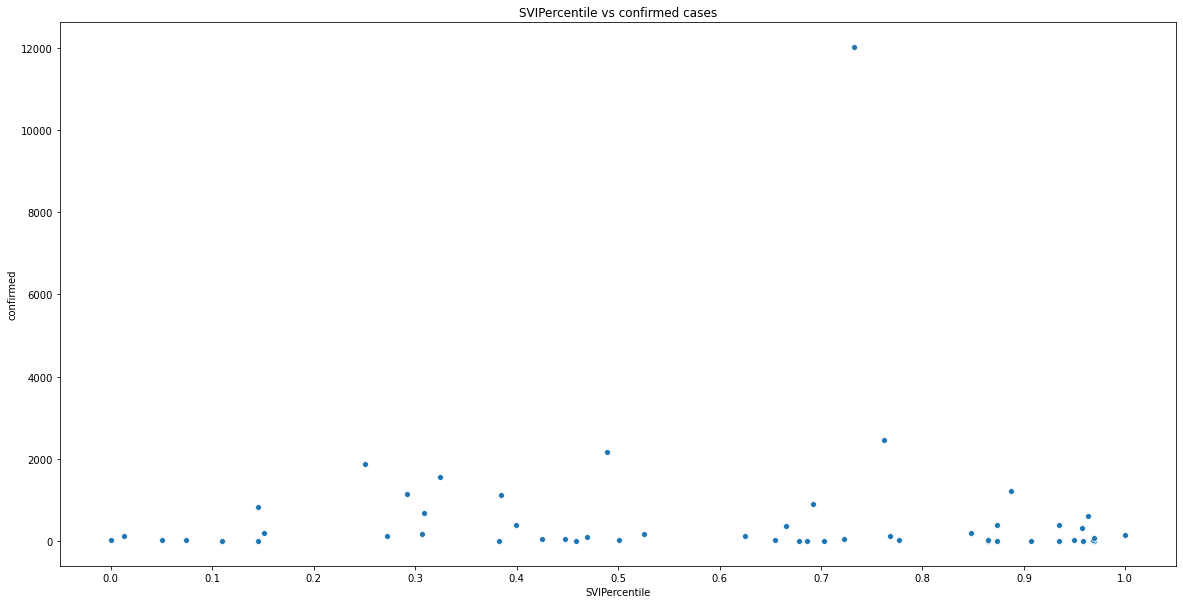

In [14]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(ca_counties["SVIPercentile"], ca_counties["confirmed"])
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title("SVIPercentile vs confirmed cases")

It was surprising to see that there was little relationship between SVI and confirmed count. One would expect a higher count of confirmed cases as SVI grows, because SVI measures how much an area is at risk for natural disasters. While there are some extremely high outliers, this shows us that SVI might not be a proper feature to use. However, because we are only using Californian data, the sample size might be too small to properly demonstrate such a relationship.


In [15]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr, te = train_test_split(ca_counties, test_size=0.2)

In [16]:
#Our training features don't require the IDs, the confirmed count, or the population estimate.
#Our used features are FractionMale2017, MedianAge2010, PopulationDensityperSqMile2010, #FTEHospitalTotal2017,
#TotalM.D.'s,TotNon-FedandFed2017, MedicareEnrollment,AgedTot2017, #ICU_beds, SVIPercentile
x_tr = tr.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_tr = tr["confirm_perc"]
x_te = te.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018",], axis = 1)
y_te = te["confirm_perc"]

#Using Linear Regression, we predict the number of confirmed cases 
model = LinearRegression()
model.fit(x_tr, y_tr)
y_pred = model.predict(x_te)

#Function that computes RMSE
def computeRMSE(y, y_hat):
    return np.sqrt(1/(len(y)) * np.sum((y - y_hat) * (y - y_hat)))

#Function that computes cross_validation
def cross_validate_rmse(model, tr_x, tr_y, n):
    model = clone(model)
    n_fold = KFold(n_splits=n)
    rmse_values = []
    for tr_ind, va_ind in n_fold.split(tr_x):
        model.fit(tr_x.iloc[tr_ind,:], tr_y.iloc[tr_ind])
        rmse_values.append(computeRMSE(tr_y.iloc[va_ind], model.predict(tr_x.iloc[va_ind,:])))
    return np.mean(rmse_values)

print("RMSE: " + str(computeRMSE(y_te, y_pred)))
print("Cross Validation RMSE: " + str(cross_validate_rmse(model, x_tr, y_tr, 5)))

weights = pd.DataFrame()
weights["Feature"] = ["FracMale2017", "MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", 
"TotalM.D.'s,TotNon-FedandFed2017", "MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]
weights["Weight"] = model.coef_
weights = weights.reindex(weights["Weight"].abs().sort_values(ascending=False).index).reset_index(drop=True)
weights

RMSE: 0.025057952418035122
Cross Validation RMSE: 0.0682213639285973


,Feature,Weight
0,"TotalM.D.'s,TotNon-FedandFed2017",-0.269119
1,"MedicareEnrollment,AgedTot2017",0.214438
2,#FTEHospitalTotal2017,0.157016
3,PopulationDensityperSqMile2010,0.075141
4,FracMale2017,0.063480
5,SVIPercentile,-0.055474
6,MedianAge2010,-0.031393
7,#ICU_beds,-0.020687


The table above ranks the features according to the magnitude of their weights. Positive weights indicate a positive correlation, meaning that the higher the feature, the higher the predicted confirmed cases we get. Negative weights indicate a negative correlation, so the higher the feature, the lower the predicted confirmed cases. It is quite interesting that "FracMale2017" is the most important for California, and with a positive correlation too. This means that the higher the males, the higher the confirmed cases the model will predict. Perhaps females are more cautious and thus treat Covid 19 more seriously, so they take more precautions. Another theory we have is that since the labor workforce comprises of more men than women, more men than women get exposed. We go further in depth in our report, and for now we will move on to analyzing the full dataset and seeing if it is similar to California or different.

In [17]:
#This follows the same process as the first few cells. We only take the features we want and rename the date column to something more meaningful.
clean_counties = counties[["countyFIPS", "PopulationEstimate2018", "FracMale2017", 
"MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", "TotalM.D.'s,TotNon-FedandFed2017", 
"MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]]
#For some features, having a value of 0 means it should get cleaned
clean_counties = clean_counties[clean_counties["SVIPercentile"] > 0]
clean_counties = clean_counties[clean_counties["PopulationEstimate2018"] > 0]
#For other features, we should just drop only NA values, as 0 is a possible value
clean_counties = clean_counties.dropna()

clean_confirm = confirmed[["FIPS", "4/18/20"]]
clean_confirm.columns = ["countyFIPS", "confirmed"]
#Cleaning clean_confirm as well because there are some rows with NaN FIPS values
clean_confirm = clean_confirm.dropna()

#convert FIPS in both dataframes into int so they can be compared when we merge
clean_counties["countyFIPS"] = clean_counties["countyFIPS"].astype(int)
clean_confirm["countyFIPS"] = clean_confirm["countyFIPS"].astype(int)
#Merge confirmed columns into counties table using FIPS.
clean_counties = clean_counties.merge(clean_confirm, on="countyFIPS")
#Remove counties without sufficient confirmed data.
clean_counties = clean_counties[clean_counties["confirmed"] > 0]

#We are going to change the confirm column into a percentage
clean_counties["confirm_perc"] = (clean_counties["confirmed"]/clean_counties["PopulationEstimate2018"])*100
#copy data for pca before we normalize the rest of the columns
clean_counties_pca = clean_counties.copy()

#
clean_counties["FracMale2017"] = normalize(clean_counties["FracMale2017"])
clean_counties["MedianAge2010"] = normalize(clean_counties["MedianAge2010"])
clean_counties["PopulationDensityperSqMile2010"] = normalize(clean_counties["PopulationDensityperSqMile2010"])
clean_counties["#FTEHospitalTotal2017"] = normalize(clean_counties["#FTEHospitalTotal2017"])
clean_counties["TotalM.D.'s,TotNon-FedandFed2017"] = normalize(clean_counties["TotalM.D.'s,TotNon-FedandFed2017"])
clean_counties["MedicareEnrollment,AgedTot2017"] = normalize(clean_counties["MedicareEnrollment,AgedTot2017"])
clean_counties["#ICU_beds"] = normalize(clean_counties["#ICU_beds"])
clean_counties["SVIPercentile"] = normalize(clean_counties["SVIPercentile"])

c:\users\rober\anaconda3\envs\py36\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log Population Density vs Logged Percentage of confirmed cases')

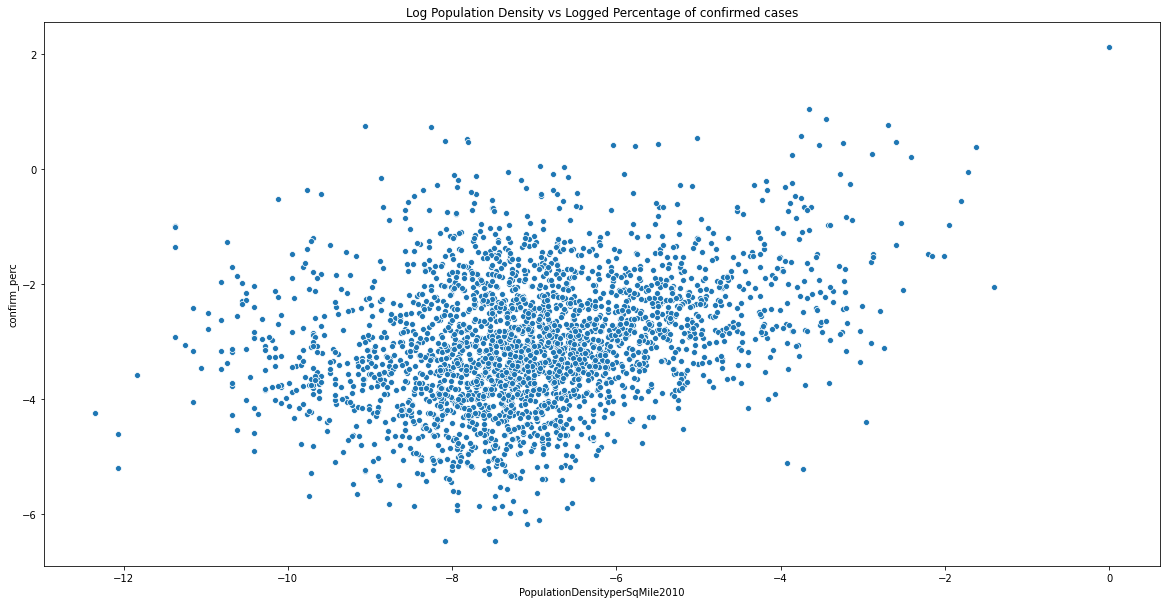

In [18]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(np.log(clean_counties["PopulationDensityperSqMile2010"]), np.log(clean_counties["confirm_perc"]))
plt.title("Log Population Density vs Logged Percentage of confirmed cases")

This graph aligns with our expectations. We expect denser counties to have more close human interactions, and thus faster spreading of Covid 19. This graph displays a positive correlation between the two variables, which showed us that population density would be a good feature to use. We also logged both sides to make the graph clearer, as before it was harder to see the correlation.

In [19]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr2, te2 = train_test_split(clean_counties, test_size=0.2)
x_tr2 = tr2.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_tr2 = tr2["confirm_perc"]
x_te2 = te2.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_te2 = te2["confirm_perc"]
#Using Linear Regression, we predict the number of confirmed cases 
model2 = LinearRegression()
model2.fit(x_tr2, y_tr2)

print("Cross Validation RMSE: " + str(cross_validate_rmse(model2, x_tr2, y_tr2, 5)))
y_hat = model2.predict(x_te2)
print("RMSE: " + str(computeRMSE(y_te2, y_hat)))

weights = pd.DataFrame()
weights["Feature"] = ["FracMale2017", "MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", 
"TotalM.D.'s,TotNon-FedandFed2017", "MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]
weights["Weight"] = model2.coef_
weights = weights.reindex(weights["Weight"].abs().sort_values(ascending=False).index).reset_index(drop=True)
weights

Cross Validation RMSE: 0.1963048022559058
RMSE: 0.18648246528260604


,Feature,Weight
0,PopulationDensityperSqMile2010,7.405253
1,#ICU_beds,-1.380153
2,"MedicareEnrollment,AgedTot2017",1.077876
3,"TotalM.D.'s,TotNon-FedandFed2017",0.783545
4,#FTEHospitalTotal2017,-0.379493
5,SVIPercentile,0.059188
6,FracMale2017,-0.008039
7,MedianAge2010,-0.000199


Overall, the ranking of features are still relatively similar to California's, with some minor changes. "FracMale2017" is still the highest in importance, with "SVIPercentile" coming in second. It measures how at risk a county is to an event like this, so it makes sense that it would be heavily weighted. All in all, California seems to be a good representation of the country as a whole, albeit with a few differences. Now, we will use PCA to see if we can find anything interesting with our features.

In [61]:
pca = clean_counties_pca.copy()
pca_cleaned = pca.drop(["countyFIPS", "confirmed", "confirm_perc", "PopulationEstimate2018"], axis = 1)
pca_centered = pca_cleaned - np.mean(pca_cleaned, axis = 0)
u, s, vt = np.linalg.svd(pca_centered, full_matrices = False)
#sigma_1 is the vector that containing the sigma value corresponding to the first pc
sigma_1 = np.array([s[0], 0, 0, 0, 0, 0, 0, 0])
#to retrieve all the values associated with pc1, we dot product u with sigma1
pc1 = u@sigma_1;
pca["pc1"] = pc1
pca

,countyFIPS,PopulationEstimate2018,FracMale2017,MedianAge2010,PopulationDensityperSqMile2010,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017","MedicareEnrollment,AgedTot2017",#ICU_beds,SVIPercentile,confirmed,confirm_perc,pc1
0,1001,55601.0,0.486578,37.0,91.8,324.0,50.0,8046.0,6.0,0.4354,25,0.044963,-9596.631813
1,1003,218022.0,0.485472,41.1,114.7,2101.0,536.0,41590.0,51.0,0.2162,109,0.049995,23879.754724
2,1005,24881.0,0.527701,39.0,31.0,181.0,12.0,4706.0,5.0,0.9959,18,0.072344,-12925.588985
3,1007,22400.0,0.535469,37.8,36.8,145.0,16.0,3389.0,0.0,0.6003,26,0.116071,-14234.627007
4,1009,57840.0,0.493114,39.0,88.9,103.0,18.0,9542.0,6.0,0.4242,20,0.034578,-8145.655894
5,1011,10138.0,0.544670,38.5,17.5,196.0,4.0,1434.0,0.0,0.8898,9,0.088775,-16164.603589
6,1013,19680.0,0.465675,40.1,27.0,330.0,18.0,3571.0,7.0,0.8653,13,0.066057,-14029.558968
7,1015,114277.0,0.480693,38.2,195.7,1694.0,228.0,20142.0,24.0,0.8252,66,0.057754,2573.899180
8,1017,33615.0,0.478747,41.5,57.4,0.0,28.0,6342.0,0.0,0.7382,240,0.713967,-11328.821474
9,1019,26032.0,0.496809,43.9,46.9,151.0,14.0,5195.0,0.0,0.4516,12,0.046097,-12445.094382


By observing the patterns of the columns and the values of the PCA, we notice that pc1 is referencing medicare enrollment. For large values, the pca value takes on a negative number, while for small enrollments, the pca takes on a smaller number.

This tells us that between different counties, medicare enrollment is the thing that differentiates them from each other the most. To tell if this could be a good feature, we need to look at the context medicare enrollment can have on confirmed cases. Having medicare implies that people will go to the hospital if sick. If someone has medicare, then they are also more likely to become confirmed. Also, the amount of people having medicare can closely relate to the population, with more people in a population means more people enrolled in medicare.

Text(0.5, 1.0, 'pc1 vs Medicare Enrollment')

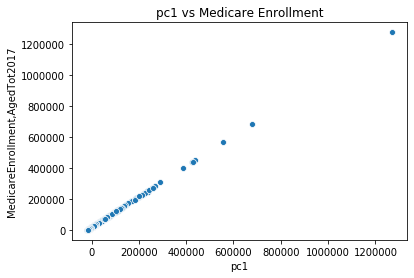

In [62]:
sns.scatterplot(pca["pc1"], pca["MedicareEnrollment,AgedTot2017"])
plt.title("pc1 vs Medicare Enrollment")

Text(0.5, 1.0, 'Medicare Enrollment vs Population Estimate')

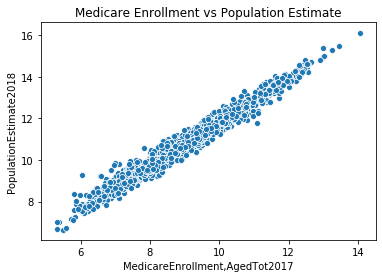

In [63]:
sns.scatterplot(np.log(pca["MedicareEnrollment,AgedTot2017"]), np.log(pca["PopulationEstimate2018"]))
plt.title("Medicare Enrollment vs Population Estimate")

As we can see, medicare does grow with population linearly, meaning choosing medicare enrollment as a feature would also be implicitly making population a sort of pseudo-feature as well. Both of these are important to determining how sickness spreads, so using Medicare Enrollment does not seem to be a bad idea. 

As we can see, PCA told us that Medicare enrollment has the highest variances. This actually lines up with the weights we received from our linear regression, as medicare is respecively high in both weight-tables. In conclusion, we found that in context with Linear Regression, fraction of males tends to matter the most for population estimates, while other features may vary more widely but have less impact. Through PCA we found that Medicare has the most variance, and based on a weight tables is also a strong contender for being one of the more important features.